In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
import scipy.interpolate
import math

mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams.update({
	'font.family':'serif',
	'mathtext.fontset' : 'cm',
	'mathtext.rm': 'serif',
	'font.weight': 'normal',
	'font.size': 10})
plt.rcParams.update({'font.size': 10})


In [224]:
class GrowthFunction:
    def __init__(self, h=0.73, omega_m=0.27,omega_l=0.73):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.H_0=h*100
    
    """
    We need to create a growth factor function. Which depends on the cosmological model.
    1) find the evolution of the densities
    2) define the growth factor
    """
    

    def Time(self, z):
        return ((2*self.H_0**(-1))/(1+(1+z)**2))
        #return 2/(3*self.H_0*(1+z)**(3/2))

    #hubble
    def E_of_z(self, redshift):
        """
        E(z) which describe the evolution of H(z)=E(z)*H0
        """
        Ez = np.sqrt(self.omega_l0 + (1.0 - self.omega_l0 
            - self.omega_m0) * (1.0+redshift)**2 
            + self.omega_m0 * (1.0+redshift)**3)

        return Ez

    #matter
    def omega_mz(self,redshift):
        return self.omega_m0 * (1.0+redshift)**3 / self.E_of_z(redshift)**2.0

    #Vacuum
    def omega_lz(self,redshift):
        return self.omega_l0 / (self.E_of_z(redshift))**2

    def g_of_z(self, redshift):
        """
        growth suppression factor
        """

        gz = 2.5 * self.omega_mz(redshift) / (self.omega_mz(redshift)**(4/7) 
        - self.omega_lz(redshift) + ((1 + self.omega_mz(redshift)/2) 
        * (1 + self.omega_lz(redshift)/70)))

        return gz

    def D_of_z(self, redshift):
        """
        growth function
        """
        return self.g_of_z(redshift) / self.g_of_z(0.0) / (1.0+redshift)
    
    def Delta_c(self, redshift):
        return 1.686/self.D_of_z(redshift)

In [109]:
class Overdensities:
    
    def __init__(self,redshift,h7=1.05,h=0.73,omega_m=0.27,omega_l=0.73, ns=0.95,sigma8=0.8,Nbins_Sigma=50,logmass_lim=(4, 20)):

        if (h<=0.0):
            raise ValueError("Overdensities(): Negative Hubble constant illegal.\n")
        elif (h>2.0):
            raise ValueError("Overdensities(): Reduced Hubble constant h should be in units of 100 km/s/Mpc.\n")
        if (h7<=0.0):
            raise ValueError("Overdensities(): Negative Hubble constant illegal.\n")
        elif (h7>2.0):
            raise ValueError("Overdensities(): Reduced Hubble constant h7 should be in units of 70 km/s/Mpc.\n")
        if (redshift<=-1.0):
            raise ValueError("Overdensities(): Redshift < -1 is illegal.\n")
        elif (redshift>4000.0):
            raise ValueError("Overdensities(): Large redshift entered.  TF may be inaccurate.\n")

        Growth = GrowthFunction(omega_m = omega_m, omega_l = omega_l)

        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.h7=h7
        self.h=h
        self.Nbins_Sigma = Nbins_Sigma
        self.ns = ns
        self.redshift = redshift
        self.logmass_max = logmass_lim[1]
        self.logmass_min = logmass_lim[0]
        self.rho_0 = self.omega_m0 * 2.78e+11
        self.rho_0 =133363631951.67577
        #WMAP pivot scale
        self.kpivot = 2e-3

        self.D_of_z = Growth.D_of_z

        #Normalization of the power spectrum
        self.N=1
        self.N=sigma8*sigma8 / (self.Sigma_of_R(self.TopHatFilter, 11.4))**2
        

        # output arrays
        # Smother radius [Mpc/h]
        self.R = np.empty(self.Nbins_Sigma,dtype='float64')
        # mass (M_sun/h)
        self.M = np.empty(self.Nbins_Sigma,dtype='float64')
        self.logM = np.empty(self.Nbins_Sigma,dtype='float64')
        #self.M = np.logspace(self.logmass_min, self.logmass_max, self.Nbins_Sigma)
        # sigma(M, z=0, where mass is in [M_sun/h])
        # array of sigma for three different filters
        self.Sigmas = np.empty(3, dtype=object)
        self.Sigmasz = np.empty(3, dtype=object)
        self.interpolates = np.empty(3, dtype=object)

        #we can initialize sigma(M) for the different filter to then interpolate
        self.Filters = (self.TopHatFilter, self.GaussianFilter, self.KSharpFilter)
        self.Ints = np.empty(3, dtype=object)

        for i in range(3):

            s, self.R = self.SigmaM_Array(self.Filters[i])
            self.Sigma = s
            self.Sigmas[i] = s
            sz = self.SigmaM_of_z()
            self.Sigmaz = sz
            self.Sigmasz[i] = sz
            interpolate = self.Interpolator()
            self.interpolates[i] = interpolate
            int = self.Sigma_of_M_and_z(self.M, interpolate)
            self.Ints[i] = int


    def TransferFunction(self, k):
        q=2.04/(self.omega_m0*self.h7**2)
        return np.log(1+2.34*q*k)/(2.34*q*k*(1+3.89*q*k+(16.1*q*k)**2+(5.46*q*k)**3+(6.71*q*k)**4)**(1/4))
    
    def PowerSpectrum(self, k):
        return self.N * self.TransferFunction(k)**2 * k * (k/self.kpivot)**(self.ns-1)
    
    """
    Now we define each filters. 
    Using the series expansion at low Rk make the integration more precised (for numerical integration).
    """

    def TopHatFilter(self, x):
        if x < 1e-2:
            return 1-x**2/10+x**4/280
            # return 1./3. - x**2/30. +x**4/840
        else:
            return 3/(x)**3*(np.sin(x)-x*np.cos(x))
        
    def GaussianFilter(self, x):
        if x < 1e-2:
            return 1-x**2/2+x**4/8
        else:
            return np.exp(-x**2/2)
        
    def KSharpFilter(self, x):
        if x <= 1:
            return 1
        else:
            return 0
    
    def integrant(self, k, R, Filter):
        return k**2*self.PowerSpectrum(k)*Filter(k*R)**2
    
    def Sigma_of_R(self, Filter, R):

        s2 = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter), epsrel=1e-2)[0]
        
        return (s2/(2*np.pi**2))**(1/2)

    def Sigma_of_M(self, Filter, M):

        if Filter == self.TopHatFilter:
            gamma_f, c = 4*np.pi/3, 1
        
        elif Filter == self.GaussianFilter:
            gamma_f, c = (2*np.pi)**(2/3), 0.643
        
        elif Filter == self.KSharpFilter:
            gamma_f, c = 6*np.pi**2, 1

        R = c*(M/(gamma_f*self.rho_0))**(1/3)

        s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2)[0]

        return (s/(2*np.pi**2))**(1/2), R
    
    def SigmaM_Array(self, Filter):
        
        s = np.empty(self.Nbins_Sigma, dtype='float64')
        R = np.empty(self.Nbins_Sigma, dtype='float64')

        dm = (self.logmass_max - self.logmass_min)/self.Nbins_Sigma

        for i in range(self.Nbins_Sigma):

            logM = self.logmass_min + i*dm

            M = 10.0**logM

            s[i], R[i]= self.Sigma_of_M(Filter, M)

            self.M[i] = M

            self.logM[i] = logM

        return s, R


    """The final function is ready to be set up"""

    def Interpolator(self):
        return scipy.interpolate.InterpolatedUnivariateSpline(self.logM, self.Sigma)

    def SigmaM_of_z(self):
        sz = self.D_of_z(self.redshift)*self.Sigma
        return sz

    def Sigma_of_M_and_z(self, M, interpolate):
        return self.D_of_z(self.redshift)*interpolate(np.log10(M))
    
    def output(self, ):
        for i in range(3):
            name=['TopHat', 'Gaussian', 'KSharp']
            plt.plot(self.M, self.Sigma_of_M_and_z(self.M, self.interpolates[i]), label = f'{name[i]}')

        plt.xscale('log')
        plt.xlabel('$M/M_{\odot}$')
        plt.ylabel('$\sigma$')
        plt.yscale('log')
        plt.legend()
        return


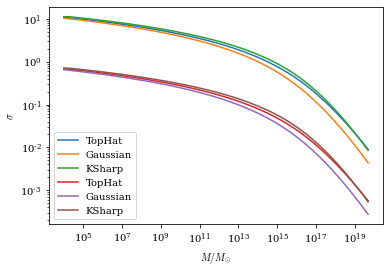

In [110]:
for i in range(2):
    Overdensity=Overdensities(i*20)
    Overdensity.output()

In [122]:
class HaloMassFunction:

    def __init__(self, redshift, omega_m=0.27, omega_l=0.73, h=1.05, ns=0.95, sigma8=0.8, mass_function=None, Nbins=50, logmass_lim=(6, 20)):
        self.overden = Overdensities(redshift, omega_m=omega_m, omega_l=omega_l, h=h, ns=ns, sigma8=sigma8, Nbins_Sigma=Nbins, logmass_lim=logmass_lim)
        self.logM=self.overden.logM
        self.M = self.overden.M
        self.interpolates=self.overden.interpolates

        if mass_function == None:
            self.mass_function = self.press_schechter
        else:
            self.mass_function = mass_function.__get__(self)

        self.redshift = redshift
        Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l)

        self.Delta_c = Growth.Delta_c

        self.dndms=np.empty(3, dtype=object)

        for i in range(3):

            dndm=self.dndm_gen(self.M, self.interpolates[i])

            self.dndms[i] = dndm

    def logderivative(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(1.1*np.log10(M))
        return (np.log(sigma_plus*sigma_plus)-np.log(sigma*sigma))/np.log(0.1*M), sigma
        
    
    def dndm_gen(self, M, interpolate):
        """Returns the halo mass function dn/dM in units of h^4 M_sun^-1 Mpc^-3
        Requires mass in units of M_sun /h """
        # Mean matter density at redshift z in units of h^2 Msolar/Mpc^3
        #This is rho_c in units of h^-1 M_sun (Mpc/h)^-3
        rho_0 = self.overden.rho_0 #self.overden.omega_matter_of_z(self.overden.redshift)

        dlogsigma, sigma = self.logderivative(M, interpolate)
        mass_func = self.mass_function(sigma)
        
        dndM =  np.abs(dlogsigma)*mass_func/M*rho_0

        return dndM
    
    def press_schechter(self, sigma):
        """Press-Schechter (This form Lacey and Cole eq. 2.11 1993)"""
        nu = self.Delta_c(self.redshift) / sigma
        return np.sqrt(1/2*np.pi) * nu * np.exp(-0.5*nu*nu)

    def sheth_tormen(self, sigma):
        """Sheth-Tormen 1999, eq. 6"""
        nu = self.Delta_c(self.redshift) / sigma
        A=0.3222
        a=0.707
        p=0.3
        return A*np.sqrt(2.0*a/math.pi)*(1.0+ np.power( 1.0/(nu*nu*a), p) )*  nu * np.exp(-0.5*a*nu*nu)

    def warren(self, sigma):
        """LANL fitting function - Warren et al. 2005, astro-ph/0506395, eqtn. 5 """
        A = 0.7234
        a = 1.625
        b = 0.2538
        c = 1.1982
        return A*( np.power(sigma, -1.0*a) + b)*np.exp(-1.0*c / sigma / sigma )

    def watson_FOF(self, sigma):
        """Watson 2012, eq. 12"""
        A = 0.282
        a = 2.163
        b = 1.406
        c = 1.210
        return A*( np.power(b / sigma, 1.0*a) + 1)*np.exp(-1.0*c / sigma / sigma )

    def output(self):
        name=['TopHat', 'Gaussian', 'KSharp']
        for i in range(3):
            plt.plot(self.M, self.dndms[i], label = f'{name[i]}')
        plt.xscale('log')
        plt.xlabel('$M/M_{\odot}$')
        plt.ylabel('$IMF$')
        plt.yscale('log')
        # plt.xlim(1e7,1e18)
        # plt.ylim(1e-12,100)
        plt.legend()
        plt.ylim(1e-12,1e1)
        plt.xlim(1e7,1e18)
        return 



In [123]:
path = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/'

data = np.genfromtxt(path + 'Binney,Tremaine.csv', delimiter=';')

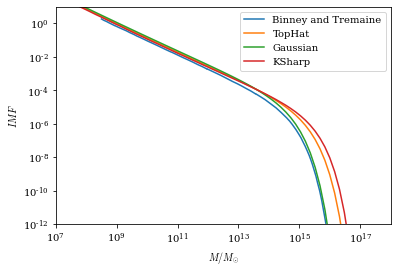

In [124]:
plt.plot(data[:,0], data[:,1], label = 'Binney and Tremaine')
HIMF=HaloMassFunction(0, logmass_lim=(4, 20), Nbins=100)
HIMF.output()

In [238]:
class MergerRate():
    def __init__(self,redshift, redshift_lim = (0, 12), M_1=5e13, omega_m=0.27, omega_l=0.73, h=0.73, ns=0.95, sigma8=0.8, Nbins=50, logmass_lim=(6, 20)):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.logmass_lim = logmass_lim
        self.sigma8 = sigma8
        self.h=h
        self.Nbins = Nbins
        self.ns = ns
        self.redshift = redshift
        self.logmass_max = logmass_lim[1]
        self.logmass_min = logmass_lim[0]
        self.rho_0 = self.omega_m0 * 2.78e+11
        self.M_1=M_1
        self.redshift_max_lim = redshift_lim[1]
        self.redshift_min_lim = redshift_lim[0]
        #self.rho_0 =133363631951.67577


        self.HMF = HaloMassFunction(redshift, omega_m=omega_m, omega_l=omega_l, h=h, ns=ns, sigma8=sigma8, Nbins=Nbins, logmass_lim=logmass_lim)
    
        Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l)

        self.Delta_c = Growth.Delta_c
        self.Time = Growth.Time
        
    """Create a merger rate at a fixed redshift in terms of the mass"""
    def MergerRate_of_M2(self):
        
        overden = Overdensities(self.redshift, omega_m=self.omega_m0, omega_l=self.omega_l0, h=self.h, ns=self.ns, sigma8=self.sigma8, 
        Nbins_Sigma = self.Nbins, logmass_lim=self.logmass_lim)

        interpolate = overden.interpolates[1]

        DeltaM = np.empty(self.Nbins, dtype=object)
        LogdeltaM = np.empty(self.Nbins, dtype=object)

        MR = np.empty(self.Nbins, dtype=object)

        logDMmin = -2
        logDMmax = 2

        dlogm = (logDMmax-logDMmin)/self.Nbins

        for i in range(self.Nbins):

            thislogDM = logDMmin + i*dlogm
            thisDM = 10**(thislogDM)*self.M_1
            thisM2 = thisDM + self.M_1

            sigma1 = interpolate(np.log10(self.M_1))
            der , sigma2 = self.logderivative(thisM2, interpolate)

            MR[i] = (2/np.pi)**(1/2)/self.Time(self.redshift)*2/3*thisDM/thisM2*np.abs(der)*self.Delta_c(self.redshift)/sigma2/(1-(sigma2/sigma1)**2)**(3/2)*np.exp(-0.5*self.Delta_c(self.redshift)**2*(1/sigma2**2-1/sigma1**2))
            DeltaM[i] = thisDM
            LogdeltaM[i] = thislogDM

        if self.redshift==1:
            MR=0.5*MR
        elif self.redshift==0:
            MR = 1.35*MR

        return MR, DeltaM, LogdeltaM



    """Create a merger rate at a fixed final mass in terms of the redshift"""
    def MergerRate_of_M2z(self, M2):

        MRs_z = np.empty(self.Nbins, dtype=object)
        z = np.empty(self.Nbins, dtype=object)
        dz = (self.redshift_max_lim - self.redshift_min_lim)/self.Nbins

        for i in range(self.Nbins):
            thisz = self.redshift_min_lim + i*dz
            z[i] = thisz

            o1 = Overdensities(thisz, omega_m=self.omega_m0, omega_l=self.omega_l0, h=self.h, ns=self.ns, sigma8=self.sigma8, 
            Nbins_Sigma = self.Nbins, logmass_lim=self.logmass_lim)
            o2 = Overdensities(thisz, omega_m=self.omega_m0, omega_l=self.omega_l0, h=self.h, ns=self.ns, sigma8=self.sigma8, 
            Nbins_Sigma = self.Nbins, logmass_lim=self.logmass_lim)

            MRs = np.empty(3, dtype=object)
            for j in range(3):
                sigma1 = o1.interpolates[j](np.log10(self.M_1))
                
                der , sigma2= self.logderivative(M2, o2.interpolates[j])
                MRs[j] = M2/np.sqrt(2*np.pi)*np.abs(2/3*self.Time(thisz)*self.Delta_c(thisz)*sigma2**2/M2*der)*(sigma1**2/sigma2**2/(sigma1**2-sigma2**2))**(3/2)*np.exp(-0.5*self.Delta_c(thisz)**2*(1/sigma2**2-1/sigma1**2))
                
                
            MRs_z[i] = MRs

        
        return z, MRs_z
            
    
    def outputM(self, color):
        MR , _, logDM = self.MergerRate_of_M2()
        plt.plot(logDM, MR, label="$M_1=${:.1e}".format(self.M_1)+f", $z=${self.redshift}", c=color)
        plt.yscale('log')
        plt.xlim(-2,2)
        plt.ylim(1e-1,10)
        plt.legend()
    
    def outputz(self):
        a, b = self.MergerRate_of_M2z(2*self.M_1)
        # plt.plot(a, b)

        print(a, b[:1])

    def logderivative(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(1.01*np.log10(M))
        return (np.log(sigma_plus)-np.log(sigma))/np.log(0.01*M), sigma




    

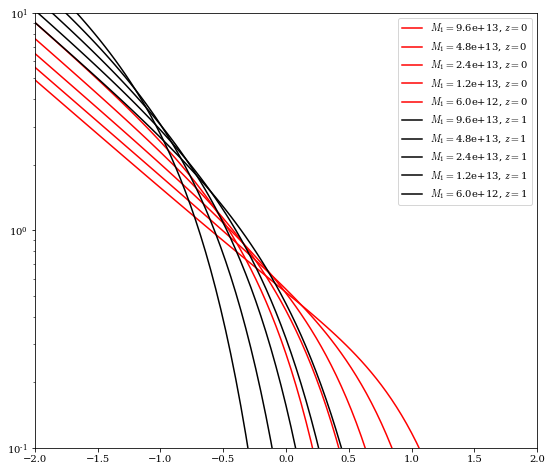

In [239]:
M_1 = [9.6e13, 4.8e13, 2.4e13, 1.2e13, 0.6e13]
Z=[0, 1]
color=['r', 'k']
plt.subplots(figsize=(9,8))
for i in range(len(Z)):
    for M in M_1:
        mergerrate = MergerRate(Z[i], h=0.5, sigma8=0.5,  M_1=M, logmass_lim=(10, 17), Nbins=100, omega_m=1, omega_l=0)
        mergerrate.outputM(color[i])

In [190]:
MR = MergerRate(1, (0, 12), M_1=1e10)
MR.outputz()

<ipython-input-109-d90808c2bfea>:125: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2)[0]


[0.0 0.24 0.48 0.72 0.96 1.2 1.44 1.68 1.92 2.16 2.4 2.6399999999999997
 2.88 3.12 3.36 3.5999999999999996 3.84 4.08 4.32 4.56 4.8 5.04
 5.279999999999999 5.52 5.76 6.0 6.24 6.4799999999999995 6.72 6.96
 7.199999999999999 7.4399999999999995 7.68 7.92 8.16 8.4 8.64
 8.879999999999999 9.12 9.36 9.6 9.84 10.08 10.32 10.559999999999999
 10.799999999999999 11.04 11.28 11.52 11.76] [array([0.0003965446621497027, 0.0004338988410257922,
       0.00036362488824518183], dtype=object)]


In [11]:
Nbins = 50
redshift_max_lim = 12
redshift_min_lim = 0
M_1=[1e10, 1e12, 1e14]


dz = (redshift_max_lim - redshift_min_lim)/Nbins

Growth = GrowthFunction(h=0.73)
Time = Growth.Time
Delta_c = Growth.Delta_c

def logderivative(M, interpolate):
            sigma = interpolate(np.log10(M))
            sigma_plus = interpolate(np.log10(1.01*M))
            return (np.log(sigma_plus*sigma_plus)-np.log(sigma*sigma))/np.log(0.01*M), sigma

In [12]:
MASTER_MR = np.empty(3, dtype=object)
z = np.linspace(redshift_min_lim, redshift_max_lim, Nbins, dtype=object)

for m in range(len(M_1)):
    M_2=2*M_1[m]
    
    MRs_z = np.zeros(Nbins, dtype=object)

    for i in range(Nbins):
        
        thisz = z[i]

        o1 = Overdensities(thisz)
        o2 = Overdensities(thisz)

        MRs = [0, 0, 0]
        for j in range(3):
            sigma1 = o1.interpolates[j](M_1[m])
            der, sigma2 = logderivative(M_2, o2.interpolates[j])
            MRs[j] = M_2/np.sqrt(2*np.pi)*np.abs(2/3*Time(thisz)*Delta_c(thisz)*sigma2**2/M_2*der)*(sigma1**2/sigma2**2/(sigma1**2-sigma2**2))**(3/2)*np.exp(-0.5*Delta_c(thisz)**2*(1/sigma2**2-1/sigma1**2))

        MRs_z[i] = MRs

    MRs_z= list(MRs_z)
    MRs_z=np.array(MRs_z)

    MASTER_MR[m] = MRs_z.T
    


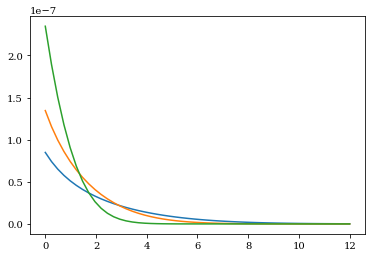

In [13]:
for i in range(3):
        plt.plot(z, MASTER_MR[i][2])
# plt.yscale('log')
# plt.ylim(0.001, 0.006)
# print(MASTER_MR)

In [14]:
MASTER_MR


array([array([[1.41342707e-07, 1.21989354e-07, 1.05802579e-07, 9.20633990e-08,
        8.02593424e-08, 7.00248788e-08, 6.10933413e-08, 5.32636967e-08,
        4.63795986e-08, 4.03162235e-08, 3.49716877e-08, 3.02612024e-08,
        2.61129552e-08, 2.24651433e-08, 1.92638109e-08, 1.64612651e-08,
        1.40149143e-08, 1.18864169e-08, 1.00410579e-08, 8.44729014e-09,
        7.07639565e-09, 5.90222899e-09, 4.90101813e-09, 4.05120244e-09,
        3.33329385e-09, 2.72975122e-09, 2.22486133e-09, 1.80462241e-09,
        1.45662782e-09, 1.16994934e-09, 9.35019911e-10, 7.43516769e-10,
        5.88246030e-10, 4.63029979e-10, 3.62598349e-10, 2.82484719e-10,
        2.18929019e-10, 1.68786864e-10, 1.29446234e-10, 9.87517826e-11,
        7.49368055e-11, 5.65627755e-11, 4.24661342e-11, 3.17119489e-11,
        2.35539381e-11, 1.74003175e-11, 1.27848884e-11, 9.34278383e-12,
        6.79030178e-12, 4.90828114e-12],
       [1.68248717e-07, 1.44331770e-07, 1.24205619e-07, 1.07050579e-07,
        9.228149

In [15]:
MRs_z

array([[2.52247849e-07, 1.67880553e-07, 2.34669175e-07],
       [1.62773067e-07, 8.83109430e-08, 1.89309071e-07],
       [9.71053315e-08, 4.05026689e-08, 1.50522006e-07],
       [5.35200487e-08, 1.61960111e-08, 1.17795636e-07],
       [2.72385481e-08, 5.64723344e-09, 9.06251319e-08],
       [1.27996176e-08, 1.71796455e-09, 6.84835890e-08],
       [5.55387698e-09, 4.56318405e-10, 5.08011097e-08],
       [2.22558009e-09, 1.05902145e-10, 3.69744098e-08],
       [8.23736111e-10, 2.14870586e-11, 2.63936750e-08],
       [2.81617954e-10, 3.81308116e-12, 1.84723226e-08],
       [8.89343229e-11, 5.92024791e-13, 1.26717132e-08],
       [2.59423277e-11, 8.04384722e-14, 8.51773078e-09],
       [6.98974449e-12, 9.56557141e-15, 5.60894704e-09],
       [1.73940772e-12, 9.95681984e-16, 3.61752904e-09],
       [3.99760289e-13, 9.07225767e-17, 2.28470249e-09],
       [8.48445935e-14, 7.23611274e-18, 1.41272066e-09],
       [1.66280842e-14, 5.05233555e-19, 8.55109203e-10],
       [3.00899313e-15, 3.08796